# Data visualization with Matplotlib

## Introduction

Mastering data visualization packages such as Matplotlib, Seaborn or Plotly are mandatory skills for a data analyst.
<br>While it is possible to do most of what you need with tools like Tableau, Power BI or Looker, packages such as Matplotlib offer a lot more, in terms of visualizations and of flexibility.

As part of my Football Analytics project, I wanted to showcase some of Matplotlib visualizations and customization features.
<br>Dataset analyzed is related to players and goals from European football championship games, from 2008 to 2016.

## Imports

In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
# from scipy.stats import norm, percentileofscore
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
# import seaborn as sns

# access env. file
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, '../'))

## Data preparation

In [2]:
goals_filepath = os.path.join(root_dir, "outputs\Goal events.csv")
shots_filepath = os.path.join(root_dir, "outputs\Shot events.csv")
players_filepath = os.path.join(root_dir, "outputs\Players information.csv")

goals_df = pd.read_csv(goals_filepath)
shots_df = pd.read_csv(shots_filepath)
players_df = pd.read_csv(players_filepath)

### Players

In [3]:
# rounding size to upper unit
players_df["player_height"] = np.round(players_df["player_height"], 0).astype("int64")
players_df = players_df.rename(columns={"player_api_id": "player"})

### All headers (attempts + goals) + player's data

In [4]:
# attempts
temp_df1 = shots_df.copy()
temp_df1 = temp_df1.loc[temp_df1["event_sub_type"].isin(["header", "big chance header", "blocked_header"])]
temp_df1 = temp_df1[["event_id", "event_type", "event_sub_type", "shot_by"]]
temp_df1["type"] = temp_df1["event_type"]
temp_df1 = temp_df1.rename(columns={"shot_by": "player", "event_type": "sub_type"})

# goals
temp_df2 = goals_df.copy()
temp_df2 = temp_df2.loc[temp_df2["event_sub_type"] == "header"]
temp_df2 = temp_df2[["event_id", "event_type", "event_sub_type", "scored_by"]]
temp_df2["type"] = "shoton"
temp_df2 = temp_df2.rename(columns={"scored_by": "player", "event_type": "sub_type"})

# concatenation
header_attempts_and_goals_df = pd.concat([temp_df1, temp_df2])

# fetching player's details
header_attempts_and_goals_df["player"].fillna(0).astype('int64')
header_attempts_and_goals_df = header_attempts_and_goals_df.merge(
    right=players_df,
    on="player",
    how="left"
)

# more cleaning
cols = ["player", "player_height", "player_weight"]
for col in cols:
    header_attempts_and_goals_df[col] = header_attempts_and_goals_df[col].fillna(0).astype('int64')

## 1 - Getting started

With just a few lines of code, it is easy to build visualizations and explore your data!

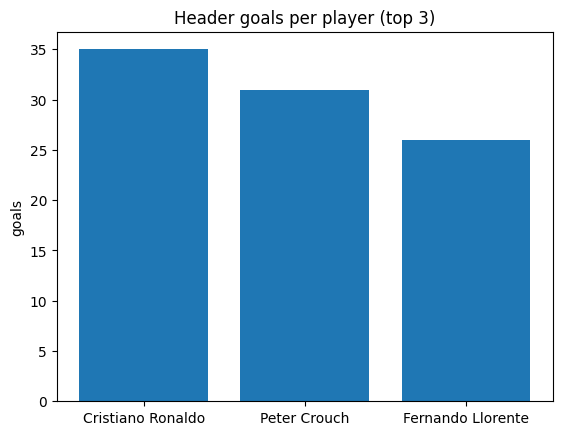

In [5]:
# data prep
top_3_goal_scorers = header_attempts_and_goals_df.loc[header_attempts_and_goals_df["sub_type"] == "goal"]
top_3_goal_scorers = top_3_goal_scorers.groupby(by="player", as_index=False).agg({"player_name": "first", "event_id": "nunique"})
top_3_goal_scorers = top_3_goal_scorers.sort_values(by="event_id", ascending=False).head(3)

# data viz
fig, ax = plt.subplots()
players = top_3_goal_scorers["player_name"]
goals = top_3_goal_scorers["event_id"]
ax.bar(players, goals)
ax.set_ylabel('goals')
ax.set_title('Header goals per player (top 3)')
plt.show()

## 2 - Limitations with basic visualizations

The above example was very straightforward, with 3 data points (3 players) to display on a bar chart.
<br>With more complex visualizations or more data points, the result may be a bit disappointing.
<br>More lines of code will be required to customize the charts.

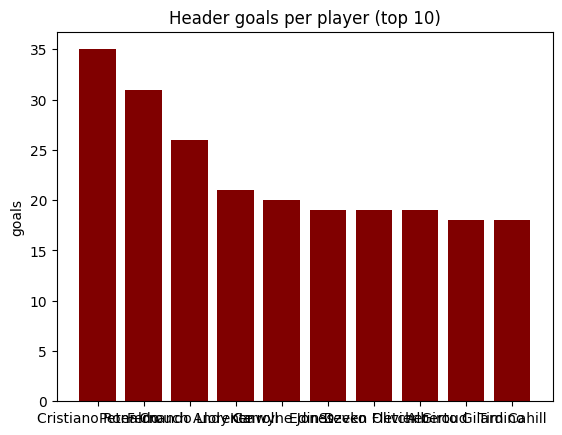

In [6]:
# data prep
top_10_goal_scorers = header_attempts_and_goals_df.loc[header_attempts_and_goals_df["sub_type"] == "goal"]
top_10_goal_scorers = top_10_goal_scorers.groupby(by="player", as_index=False).agg({"player_name": "first", "event_id": "nunique"})
top_10_goal_scorers = top_10_goal_scorers.sort_values(by="event_id", ascending=False).head(10)

players = top_10_goal_scorers["player_name"]
goals = top_10_goal_scorers["event_id"]

# data viz
fig, ax = plt.subplots()
ax.bar(players, goals, color="#800000")
ax.set_ylabel('goals')
ax.set_title('Header goals per player (top 10)')
plt.show()

## 3 - Customization

Below are some examples of how to customize your matplotlib visualizations for more readable, more efficient visualizations.

### A - Labels

1) each artist / bar of the chart coordinates must be fetched (bar.get_x(), bar.get_y())
2) each artist dimensions must be fetched (bar.get_width(), bar.get_height())
3) a legend is plot with the function ax.text()
4) each label is positioned with dedicated coordinates
    - x coordinate will be it's x position + it's width divided by 2 (so that it is centered)
    - y coordinate will be it's height, to which you can add +1 / +2 (to be slightly above bar)

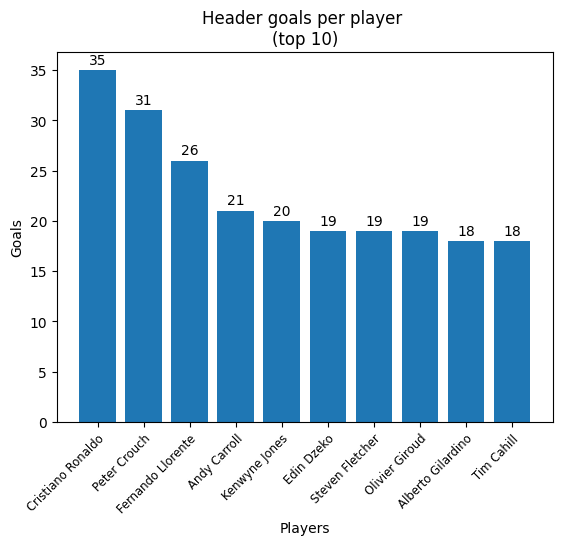

In [7]:
# data viz

# creating a single figure with 1 "plot container" (axes)
fig, ax = plt.subplots()

# creating bars
bars = ax.bar(players, goals)

# adding title, x and y labels
ax.set_title("Header goals per player \n(top 10)") # \n for line return
ax.set_ylabel("Goals")
ax.set_xlabel("Players")

# adding bar labels
for bar, value in zip(bars, goals):
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,
        y=bar.get_height() + 1,
        s=value,
        ha="center",
        va="center",
        color="black"
    )

# 45 degree rotation, using both horizontal alignment and rotation mode for best readability
plt.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize="small")

plt.show()

### B - Color gradients

1) Purpose is to use the "alpha" parameter, or transparency parameter, ranging from 0 (transparent) to 1 (opaque)
2) Key is to normalize values (min-max scaling from 0 to 1) of your chart (value / max value of the chart)

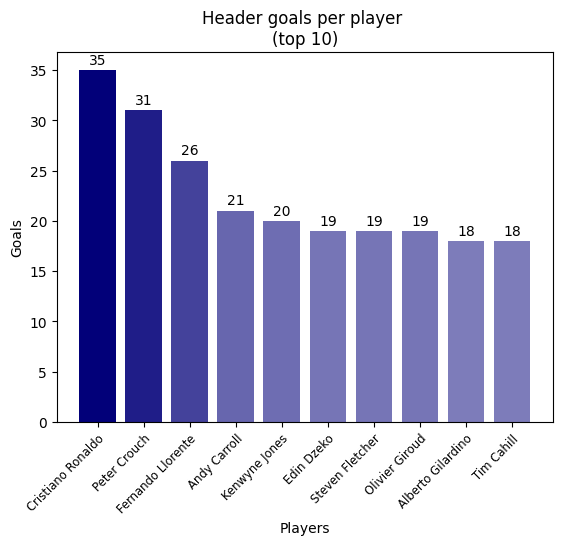

In [8]:
# data viz

# adding a color gradient
# this is done by normalizing the data on a 0-1 scale (where 0 is the min value, 1 the max number of goals)
normalized_goals = np.array(goals) / max(goals)
colors = [("#020079", alpha) for alpha in normalized_goals]

# creating a single figure with 1 "plot container" (axes)
fig, ax = plt.subplots()

# creating bars
bars = ax.bar(players, goals, color=colors)

# adding bar labels
for bar, value in zip(bars, goals):
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,
        y=bar.get_height() + 1,
        s=value,
        ha="center",
        va="center",
        color="black"
    )

# adding title, x and y labels
ax.set_title("Header goals per player \n(top 10)") # \n for line return
ax.set_ylabel("Goals")
ax.set_xlabel("Players")

# 45 degree rotation, using both horizontal alignment and rotation mode for best readability
plt.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize="small")

plt.show()

### C - Legend

A legend is an artist made of handles, which are "legend items".
<br>Each handle contains a color patch and a label.

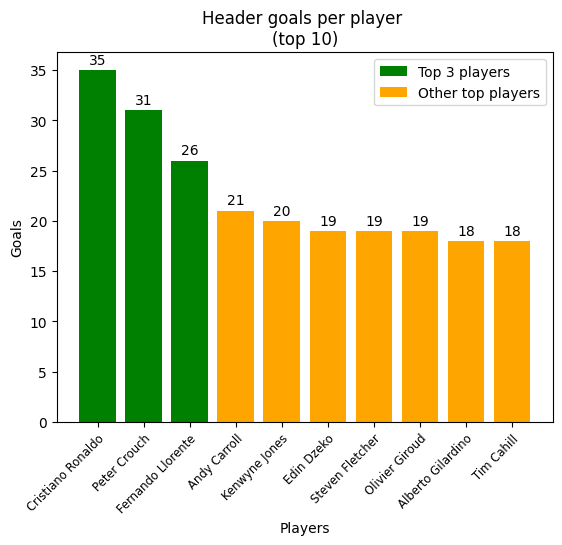

In [9]:
# data viz

# adding a color based on the values: top 3 players are in green, other players are in orange
colors = ["green" if i < 3 else "orange" for i in range(len(top_10_goal_scorers))]

# adding handles
handles = [
    mpatches.Patch(facecolor="green", label="Top 3 players"),
    mpatches.Patch(facecolor="orange", label="Other top players")
]

# creating a single figure with 1 "plot container" (axes)
fig, ax = plt.subplots()

# creating bars
bars = ax.bar(players, goals, color=colors)

# legend
plt.legend(handles=handles)

# adding bar labels
for bar, value in zip(bars, goals):
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,
        y=bar.get_height() + 1,
        s=value,
        ha="center",
        va="center",
        color="black"
    )

# adding title, x and y labels
ax.set_title("Header goals per player \n(top 10)") # \n for line return
ax.set_ylabel("Goals")
ax.set_xlabel("Players")

# 45 degree rotation, using both horizontal alignment and rotation mode for best readability
plt.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize="small")

plt.show()